In [4]:
import glob
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [77]:
domain_id = 7
trial_id = 33
water_year = 2023
multi_tile = 0

domains_direc = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/ASO/selected/'
pathh = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/'
pathh += 'domain'+str(domain_id).zfill(2)+'_trial'+str(trial_id).zfill(2)+'/'

short_name = 'MOD10A1F'
var = 'CGF_NDSI_Snow_Cover'
buffer = 5000

In [78]:
modis_files = sorted(glob.glob(pathh+short_name+'*.hdf'))
print(modis_files[:10])
print(len(modis_files))

dom_ref = domains_direc+'domain'+str(domain_id).zfill(2)+'_trial'+str(trial_id).zfill(2)+'.tif'
dom_ref = xr.open_dataset(dom_ref).isel(band=0).rio.reproject(4326)

lim_test = dom_ref.rio.reproject("PROJCS[\"MODIS Sinusoidal\",GEOGCS[\"GCS_unnamed ellipse\",DATUM[\"D_unknown\",SPHEROID[\"Unknown\",6371007.181,0]],PRIMEM[\"Greenwich\",0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Sinusoidal\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",0.0],UNIT[\"Meter\",1.0]]")
# x_lims = [dom_ref.x.mean().values-buffer,dom_ref.x.mean().values+buffer]
# y_lims = [dom_ref.y.mean().values-buffer,dom_ref.y.mean().values+buffer]
x_lims = [lim_test.x.mean().values-buffer,lim_test.x.mean().values+buffer]
y_lims = [lim_test.y.mean().values-buffer,lim_test.y.mean().values+buffer]
# bounding_box = str(x_lims[0])+','+str(y_lims[0])+','+str(x_lims[1])+','+str(y_lims[1])
print(x_lims,y_lims)
# print(bounding_box)

['/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022244.h09v05.061.2022246051414.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022245.h09v05.061.2022247050304.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022246.h09v05.061.2022248033737.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022247.h09v05.061.2022249040233.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022248.h09v05.061.2022250051003.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022249.h09v05.061.2022251033432.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022250.h09v05.061.2022258061656.hdf', '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/d

In [79]:
def sample_bounds(ds):
        # Assume `metadata_str` contains the contents of `ds.attrs['StructMetadata.0']`
    metadata_str = ds.attrs['StructMetadata.0']

    # Use regular expressions to extract the needed metadata values
    upper_left_match = re.search(r"UpperLeftPointMtrs=\(([-\d.]+),([-\d.]+)\)", metadata_str)
    lower_right_match = re.search(r"LowerRightMtrs=\(([-\d.]+),([-\d.]+)\)", metadata_str)
    x_dim_match = re.search(r"XDim=(\d+)", metadata_str)
    y_dim_match = re.search(r"YDim=(\d+)", metadata_str)

    # Extract and convert the values if the matches are found
    if upper_left_match and lower_right_match and x_dim_match and y_dim_match:
        upper_left_x, upper_left_y = map(float, upper_left_match.groups())
        lower_right_x, lower_right_y = map(float, lower_right_match.groups())
        x_dim = int(x_dim_match.group(1))
        y_dim = int(y_dim_match.group(1))

#         # Display the results
#         print("Upper Left:", (upper_left_x, upper_left_y))
#         print("Lower Right:", (lower_right_x, lower_right_y))
#         print("Dimensions:", (x_dim, y_dim))
    else:
        print("Metadata values not found.")
    return lower_right_x,lower_right_y,upper_left_x,upper_left_y,x_dim,y_dim

def assign_and_grid(ds,lower_right_x,lower_right_y,upper_left_x,upper_left_y,x_dim,y_dim):
    # Calculate resolution in meters per pixel
    x_res = (lower_right_x - upper_left_x) / x_dim
    y_res = (lower_right_y - upper_left_y) / y_dim

    # Generate coordinates
    x = np.linspace(upper_left_x, lower_right_x - x_res, x_dim)
    y = np.linspace(upper_left_y, lower_right_y - y_res, y_dim)

    # Assign the coordinates to the dataset
    # ds = ds.assign_coords({"x": ("XDim", x), "y": ("YDim", y)})
    ds = ds.assign_coords({"x": ("XDim:MOD_Grid_Snow_500m", x), "y": ("YDim:MOD_Grid_Snow_500m", y)})
    ds = ds.rename({"XDim:MOD_Grid_Snow_500m": "x", "YDim:MOD_Grid_Snow_500m": "y"})
    return ds

def reproject_func(ds,var,dom_ref,x_lims,y_lims):
    ds = ds[var]
    ds.rio.write_crs("PROJCS[\"MODIS Sinusoidal\",GEOGCS[\"GCS_unnamed ellipse\",DATUM[\"D_unknown\",SPHEROID[\"Unknown\",6371007.181,0]],PRIMEM[\"Greenwich\",0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Sinusoidal\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",0.0],UNIT[\"Meter\",1.0]]", inplace=True)
#     ds = ds.rio.reproject(dom_ref.rio.crs,resolution=(resolution,resolution))
#     ds.rio.reproject_match(dom_ref).plot(vmax=100)
    ds = ds.sel(x=slice(x_lims[0],x_lims[1]),y=slice(y_lims[1],y_lims[0]))
    return ds

2400 2400
463.3127165279165 -463.3127165279167
None
PROJCS["MODIS Sinusoidal",GEOGCS["GCS_unnamed ellipse",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


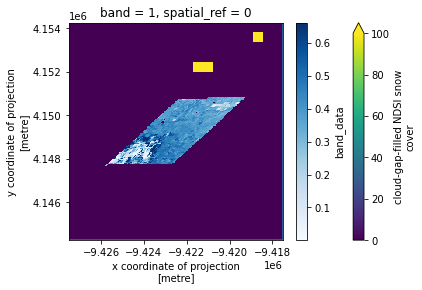

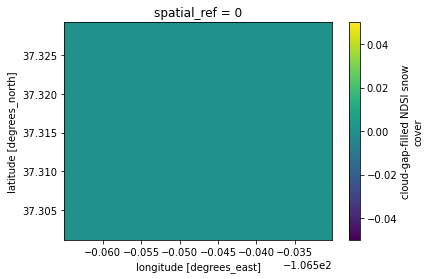

In [80]:
ds = xr.open_dataset(modis_files[20],engine='netcdf4')

metadata_str = ds.attrs['StructMetadata.0']
# Use regular expressions to extract the needed metadata values
upper_left_match = re.search(r"UpperLeftPointMtrs=\(([-\d.]+),([-\d.]+)\)", metadata_str)
lower_right_match = re.search(r"LowerRightMtrs=\(([-\d.]+),([-\d.]+)\)", metadata_str)
x_dim_match = re.search(r"XDim=(\d+)", metadata_str)
y_dim_match = re.search(r"YDim=(\d+)", metadata_str)

# Extract and convert the values if the matches are found
if upper_left_match and lower_right_match and x_dim_match and y_dim_match:
    upper_left_x, upper_left_y = map(float, upper_left_match.groups())
    lower_right_x, lower_right_y = map(float, lower_right_match.groups())
    x_dim = int(x_dim_match.group(1))
    y_dim = int(y_dim_match.group(1)) 
print(x_dim,y_dim)

x_res = (lower_right_x - upper_left_x) / x_dim
y_res = (lower_right_y - upper_left_y) / y_dim
print(x_res,y_res)

# Generate coordinates
x = np.linspace(upper_left_x, lower_right_x - x_res, x_dim)
y = np.linspace(upper_left_y, lower_right_y - y_res, y_dim)

ds = ds.assign_coords({"x": ("XDim:MOD_Grid_Snow_500m", x), "y": ("YDim:MOD_Grid_Snow_500m", y)})
ds = ds.rename({"XDim:MOD_Grid_Snow_500m": "x", "YDim:MOD_Grid_Snow_500m": "y"})
ds = ds['CGF_NDSI_Snow_Cover']
print(ds.rio.crs)

ds.rio.write_crs("PROJCS[\"MODIS Sinusoidal\",GEOGCS[\"GCS_unnamed ellipse\",DATUM[\"D_unknown\",SPHEROID[\"Unknown\",6371007.181,0]],PRIMEM[\"Greenwich\",0],UNIT[\"Degree\",0.0174532925199433]],PROJECTION[\"Sinusoidal\"],PARAMETER[\"false_easting\",0.0],PARAMETER[\"false_northing\",0.0],PARAMETER[\"central_meridian\",0.0],UNIT[\"Meter\",1.0]]", inplace=True)
print(ds.rio.crs)

fg,ax = plt.subplots()
ds.plot(ax=ax,vmin=0,vmax=100)
ax.plot([x_lims[0],x_lims[1],x_lims[1],x_lims[0],x_lims[0]],
       [y_lims[0],y_lims[0],y_lims[1],y_lims[1],y_lims[0]])
lim_test['band_data'].plot(ax=ax,cmap='Blues')
ax.set_xlim([x_lims[0],x_lims[1]])
ax.set_ylim([y_lims[0],y_lims[1]])

ds_regrid = ds.rio.reproject_match(dom_ref)
fg,ax = plt.subplots()
ds_regrid.plot(ax=ax)

In [81]:
# year_vals,day_vals = [],[]
date_list = []
ds_concat = []
for fCount,file in enumerate(modis_files):
    print(file)
    
    ds = xr.open_dataset(file, engine="netcdf4")    
    lower_right_x,lower_right_y,upper_left_x,upper_left_y,x_dim,y_dim = sample_bounds(ds)
    ds = assign_and_grid(ds,lower_right_x,lower_right_y,upper_left_x,upper_left_y,x_dim,y_dim)
    ds = reproject_func(ds,var,dom_ref,x_lims,y_lims)
    ds = ds.where(ds <= 100)
    
    if len(ds.values[~np.isnan(ds.values)]) > 0:
        print(ds.shape)
#         fg,ax = plt.subplots()
#         ds.plot(ax=ax,vmin=0,vmax=100)
#         ax.set_title(fCount)
        
        subsamp = file.split('/')[-1].split('.')[1]
        date_list.append(np.datetime64(datetime.date(int(subsamp[1:5]),1,1)+datetime.timedelta(days=int(subsamp[5:9])-1)))
        ds_concat.append(ds)
      
#     if fCount == 20:
#         break

ds_concat = xr.concat(ds_concat,dim="time")
ds_concat['time'] = ('time', date_list)

/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022244.h09v05.061.2022246051414.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022245.h09v05.061.2022247050304.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022246.h09v05.061.2022248033737.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022247.h09v05.061.2022249040233.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022248.h09v05.061.2022250051003.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022249.h09v05.061.2022251033432.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022250.h09v05.061.2022258061656.hdf
(22, 22)
/Users/jpflug/Documents/Pro

(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022307.h09v05.061.2022309083356.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022308.h09v05.061.2022310064703.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022309.h09v05.061.2022311093927.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022310.h09v05.061.2022312075614.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022311.h09v05.061.2022313071904.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022312.h09v05.061.2022315072950.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2022313.h09v05.061.2022315221553.hdf
(22, 22)
/Users/jpflug/Docu

(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023005.h09v05.061.2023009144409.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023006.h09v05.061.2023009231547.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023007.h09v05.061.2023014122337.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023008.h09v05.061.2023014165735.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023009.h09v05.061.2023014185809.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023010.h09v05.061.2023019090310.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023011.h09v05.061.2023019174855.hdf
(22, 22)
/Users/jpflug/Docu

(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023068.h09v05.061.2023070154829.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023069.h09v05.061.2023071032919.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023070.h09v05.061.2023073015220.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023071.h09v05.061.2023073041330.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023072.h09v05.061.2023074102704.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023073.h09v05.061.2023075035510.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023074.h09v05.061.2023076040951.hdf
(22, 22)
/Users/jpflug/Docu

(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023128.h09v05.061.2023130034025.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023129.h09v05.061.2023131043952.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023130.h09v05.061.2023132050612.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023131.h09v05.061.2023135234339.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023132.h09v05.061.2023136002836.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023133.h09v05.061.2023136011521.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023134.h09v05.061.2023136033412.hdf
(22, 22)
/Users/jpflug/Docu

(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023189.h09v05.061.2023198205441.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023190.h09v05.061.2023199035854.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023191.h09v05.061.2023199140611.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023192.h09v05.061.2023199190813.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023193.h09v05.061.2023199221547.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023194.h09v05.061.2023200031904.hdf
(22, 22)
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/MOD10A1F.A2023195.h09v05.061.2023200061758.hdf
(22, 22)
/Users/jpflug/Docu

In [82]:
if multi_tile:
    # Group by unique times
    grouped = ds_concat.groupby('time')

    # Apply nanmean to each group, keeping it as an xarray.DataArray
    ds_concat = grouped.map(
        lambda group: xr.DataArray(
            np.nanmean(group, axis=0),  # Compute nanmean along the time axis
            dims=group.dims[1:],       # Keep the original spatial dimensions
            coords={dim: group.coords[dim] for dim in group.dims[1:]}  # Preserve coordinates
        )
    )

    # Check the resulting DataArray
    # print(ds_concat)

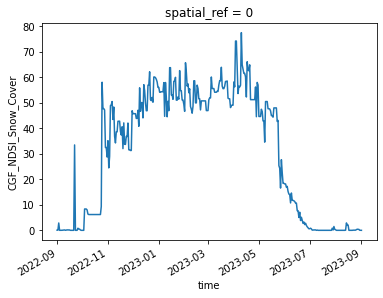

In [83]:
ds_concat.mean(dim=('x','y')).plot()

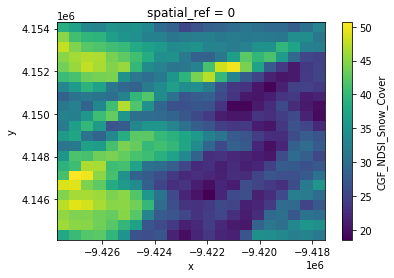

In [84]:
ds_concat.mean(dim='time').plot()

In [85]:
# for now
outfile = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain'
outfile += str(domain_id).zfill(2)+'_trial'+str(trial_id).zfill(2)
outfile += '/processed_WY'+str(water_year)+'.nc'
print(outfile)
ds_concat.to_netcdf(outfile)

/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/domain07_trial33/processed_WY2023.nc


In [11]:
ds_concat

<xarray.DataArray 'CGF_NDSI_Snow_Cover' (time: 365, y: 21, x: 21)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * x            (x) float64 -1.015e+07 -1.015e+07 ... -1.014e+07 -1.014e+07
  * y            (y) float64 4.562e+06 4.562e+06 ... 4.553e+06 4.553e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2018-09-01 2018-09-02 ... 2019-09-01
Attributes:
    long_name:    cloud-gap-filled NDSI snow cover
    valid_range:  [  0 100]
    Key:          0-100=NDSI snow, 200=missing data, 201=no decision, 211=nig...